<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/07_mileston_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big



In [ ]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-94edc68a-afa8-b2d6-be1c-6aa3fc60a4e3)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(100, 100), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

## Check GPU

Google Colab offers free GPUs, however not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (Not compatible)
* Tesla T4 (Compatible)

Knowing this, in order to use mixed precision training, we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ [(see here)](https://developer.nvidia.com/cuda-gpus)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision



In [ ]:
# Use mixed precision only with Tesla T4 GPU

#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

## Get helper function

In past modules we've created a bunch of helper functions to do small tasks reuired for our notebooks.

Rather than rewriting all of this, we can import a script and load it in from there.

The script we have got available can be found in [Github](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py).


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-03 11:10:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-03 11:10:00 (134 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


## Use TensorFlow Datasets to download data

If we want to get an overview of TensorFlow Datsets, [read the guide](https://tensorflow.org/datasets/overview)

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
dataset_list = tfds.list_builders()
print("food101" in dataset_list)

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), dsinfo = tfds.load(name="food101",
                                            split=["train","validation"],
                                            shuffle_files=True,
                                            as_supervised=True, # data gets returned in tuple format (data, label)
                                            with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete3BXU9W/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete3BXU9W/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* class names,
* shape of input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class name?

In [ ]:
# Features of Food101 from tfds
dsinfo.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class name
class_names = dsinfo.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

In [ ]:
# What does one sample of our training data look like
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  class name (str form): cheesecake
  


In [ ]:
# What does our image tensor form TFDS's Food101 look like?
#image

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

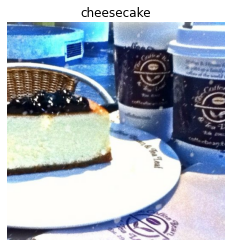

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image);
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated to the right image
plt.axis(False);

## Create preprocessing functions for our data

> **Note -** Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc...)

However, not all data (including data from TensorFlow datasets) come like this.

So in order to get it ready for a neural network you'll often have to write preprocessing functions and map it to our own data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (pixel values are between 0 and 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (Values between 0 and 1) also called normalized tensors generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built in).

this means our function needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`



In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8'-> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  # Reshape target image
  image = tf.image.resize(image, [img_shape, img_shape])
  
  # return (float32 image, label) tuple
  return tf.cast(image, tf.float32), label

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch and prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, It is highly recommended going through the [following guide](https://tensorflow.org/guide/data_performance)

In [ ]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together. And finally, make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) through the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:

* TensorBoard callback to log training results (so we can visualize them later if needed)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create model checkpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      verbose=0)

# Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision, check out the TensorFlow [guide for mixed precision](https://tensorflow.org/guide/mixed_precision)

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

# Set global data policy to mixed precision
mixed_precision.set_global_policy("mixed_float16") 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-94edc68a-afa8-b2d6-be1c-6aa3fc60a4e3)


## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can do the following:
# x = preprocessing.Rescaling(1./255)(x)

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision=)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above, we see:

* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: Is the layer trainable or not? If not, the layers are frozen.
* `layer.dtype`: The datatype a layer stores its variables in
* `layer.dtype_policy`: the datatype policy layer computes on its variable with

In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

## fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:

1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [ ]:
starting_epochs = 3
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     steps_per_epoch=len(train_data),
                                                     epochs=starting_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     callbacks=[model_checkpoint,
                                                                create_tensorboard_callback(dir_name="food_vision",
                                                                                            experiment_name="feature_extractor")]
                                                     )

Saving TensorBoard log files to: food_vision/feature_extractor/20220803-111533
Epoch 1/3
2368/2368 [==============================] - 125s 45ms/step - loss: 1.8238 - accuracy: 0.5560 - val_loss: 1.2246 - val_accuracy: 0.6793
Epoch 2/3
2368/2368 [==============================] - 109s 46ms/step - loss: 1.2943 - accuracy: 0.6662 - val_loss: 1.1284 - val_accuracy: 0.7026
Epoch 3/3
2368/2368 [==============================] - 108s 45ms/step - loss: 1.1433 - accuracy: 0.7030 - val_loss: 1.0947 - val_accuracy: 0.7060


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)

790/790 [==============================] - 31s 39ms/step - loss: 1.0949 - accuracy: 0.7049


## Save the whole model

In [ ]:
# Save model in Google Drive
model.save("drive/MyDrive/tensorflow-stuff/all_in_bigdog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow-stuff/all_in_bigdog_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow-stuff/all_in_bigdog_model/assets


In [ ]:
# Load model previously saved above
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow-stuff/all_in_bigdog_model")

In [ ]:
# Check te layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.dtype_policy)

input_1 <Policy "float32">
rescaling <Policy "mixed_float16">
normalization <Policy "mixed_float16">
stem_conv_pad <Policy "mixed_float16">
stem_conv <Policy "mixed_float16">
stem_bn <Policy "mixed_float16">
stem_activation <Policy "mixed_float16">
block1a_dwconv <Policy "mixed_float16">
block1a_bn <Policy "mixed_float16">
block1a_activation <Policy "mixed_float16">
block1a_se_squeeze <Policy "mixed_float16">
block1a_se_reshape <Policy "mixed_float16">
block1a_se_reduce <Policy "mixed_float16">
block1a_se_expand <Policy "mixed_float16">
block1a_se_excite <Policy "mixed_float16">
block1a_project_conv <Policy "mixed_float16">
block1a_project_bn <Policy "mixed_float16">
block2a_expand_conv <Policy "mixed_float16">
block2a_expand_bn <Policy "mixed_float16">
block2a_expand_activation <Policy "mixed_float16">


In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_feature_extract_loaded_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 33s 40ms/step - loss: 1.0949 - accuracy: 0.7049


In [ ]:
results_feature_extract_model

[1.094879150390625, 0.7049108743667603]

In [ ]:
results_feature_extract_loaded_model

[1.0948784351348877, 0.7049108743667603]

## Preparing our model's layers for fine-tuning

**Next :** Fine tune the feature extraction model to beat the [DeepFood](https://arxiv.org/pdf/1606.05675.pdf) paper.

In [ ]:
results_feature_extract_model

[1.094879150390625, 0.7049108743667603]

Now we see all results together:

In [ ]:
print(f"First feature extractor: {results_feature_extract_model}")
print(f"Loaded feature extractor: {results_feature_extract_loaded_model}")


First feature extractor: [1.094879150390625, 0.7049108743667603]
Loaded feature extractor: [1.0948784351348877, 0.7049108743667603]


In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they are unfrozen)
loaded_model.trainable = True

# Load feature extractor weights
loaded_model.load_weights("model_checkpoints/cp.ckpt")

In [ ]:
# Check to see dtype_policy of the layers in your loaded model are
for layer in loaded_model.layers:
  print(layer.name, layer.dtype_policy)

input_layer <Policy "float32">
efficientnetb0 <Policy "mixed_float16">
global_average_pooling2d <Policy "mixed_float16">
dense <Policy "mixed_float16">
softmax_float32 <Policy "float32">


With the layers set to trainable, we can create now the callbacks for our model. Since we are fine-tuning, we want to save only the weights of the best model, monitoring validation loss, or `"val_loss"`

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  monitor="val_loss")


# Setup model checkpoints
checkpoint_path = "fine_tuned_model_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      verbose=0,
                                                      monitor="val_loss",
                                                      save_best_only=True)

# Setup variable learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
loaded_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(0.0001),
                       metrics=["accuracy"])

In [ ]:
history_finetuned_all_layers_gs_model = loaded_model.fit(train_data,
                                                            epochs=100,
                                                            steps_per_epoch=len(train_data),
                                                            validation_data=test_data,
                                                            validation_steps=int(0.15*len(test_data)),
                                                            callbacks=[model_checkpoint,
                                                                       early_stopping,
                                                                       reduce_lr,
                                                                       create_tensorboard_callback("allin_bigdog_model","finetune_all_layers_100_epochs")])

Saving TensorBoard log files to: allin_bigdog_model/finetune_all_layers_100_epochs/20220803-112322
Epoch 1/100
2368/2368 [==============================] - 320s 129ms/step - loss: 0.9217 - accuracy: 0.7538 - val_loss: 0.8799 - val_accuracy: 0.7582 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 304s 128ms/step - loss: 0.5737 - accuracy: 0.8401 - val_loss: 0.7834 - val_accuracy: 0.7868 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 304s 128ms/step - loss: 0.3293 - accuracy: 0.9055 - val_loss: 0.8266 - val_accuracy: 0.7942 - lr: 1.0000e-04
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9491
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 303s 127ms/step - loss: 0.1704 - accuracy: 0.9491 - val_loss: 0.9814 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 303s 127ms/step 

In [ ]:
loaded_model.save("drive/MyDrive/tensorflow-stuff/all_in_bigdog_model_finetuned")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow-stuff/all_in_bigdog_model_finetuned/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow-stuff/all_in_bigdog_model_finetuned/assets


In [ ]:
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 32s 40ms/step - loss: 1.0625 - accuracy: 0.7978


In [ ]:
loaded_model_results

[1.0624674558639526, 0.7977821826934814]

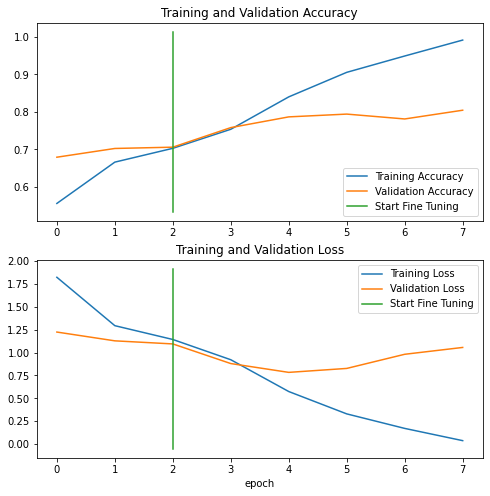

In [ ]:
compare_historys(history_101_food_classes_feature_extract,
                 history_finetuned_all_layers_gs_model,
                 initial_epochs=3)

In [ ]:
# To get the labels (y_true) for the confusion matrix and classification report, we need to unravel the test_data BatchDataset
y_true = []
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())


In [ ]:
# Make the model predict on the test data, get prediction probabilities
pred_probs = loaded_model.predict(test_data)

# Extract the argument from the maximum value, of axis 1
y_pred = pred_probs.argmax(axis=1)
y_pred

array([29, 81, 91, ..., 53, 11, 87])

In [ ]:
y_true[:10]

[28, 12, 4, 66, 55, 32, 19, 42, 63, 91]

In [ ]:
y_pred[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

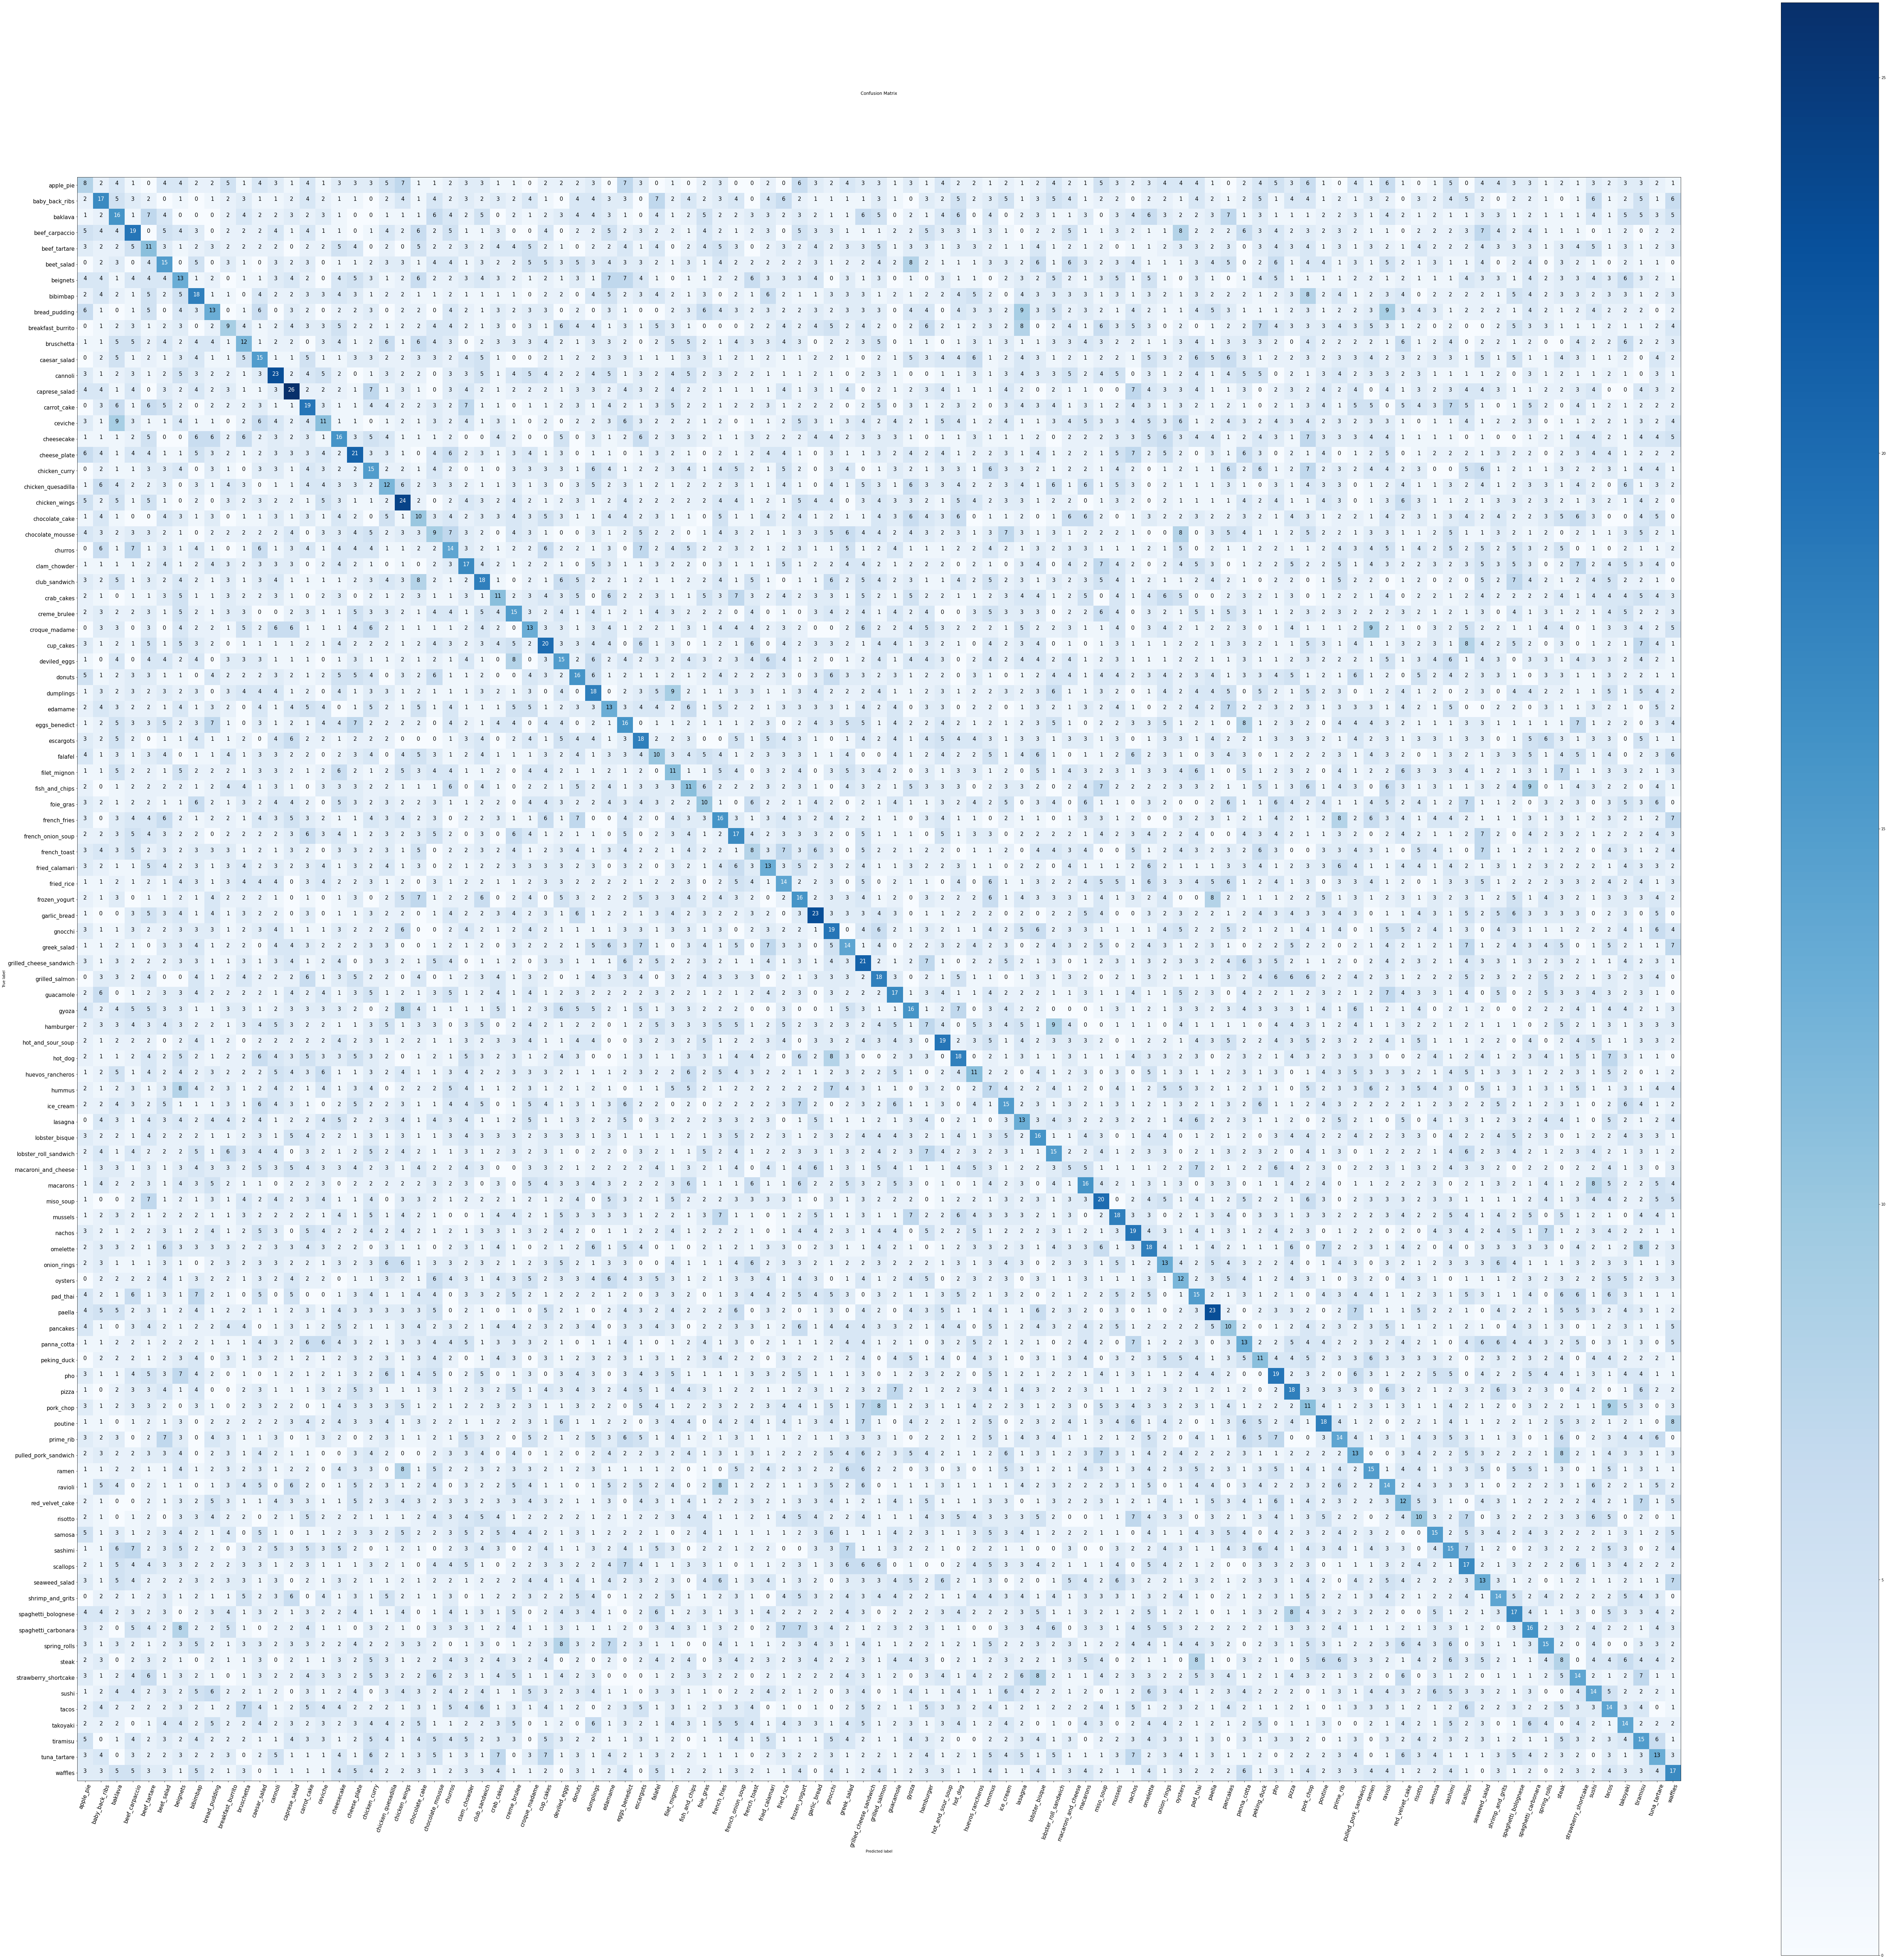

In [ ]:
make_confusion_matrix(y_true, 
                      y_pred, 
                      classes=class_names,
                      savefig=True)

In [ ]:
classification_report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=class_names)
print(classification_report(y_true, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.04      0.03      0.03       250
         baby_back_ribs       0.07      0.07      0.07       250
                baklava       0.06      0.06      0.06       250
         beef_carpaccio       0.08      0.08      0.08       250
           beef_tartare       0.04      0.04      0.04       250
             beet_salad       0.06      0.06      0.06       250
               beignets       0.05      0.05      0.05       250
               bibimbap       0.07      0.07      0.07       250
          bread_pudding       0.06      0.05      0.06       250
      breakfast_burrito       0.04      0.04      0.04       250
             bruschetta       0.05      0.05      0.05       250
           caesar_salad       0.06      0.06      0.06       250
                cannoli       0.09      0.09      0.09       250
          caprese_salad       0.10      0.10      0.10       250
            carrot_cake 

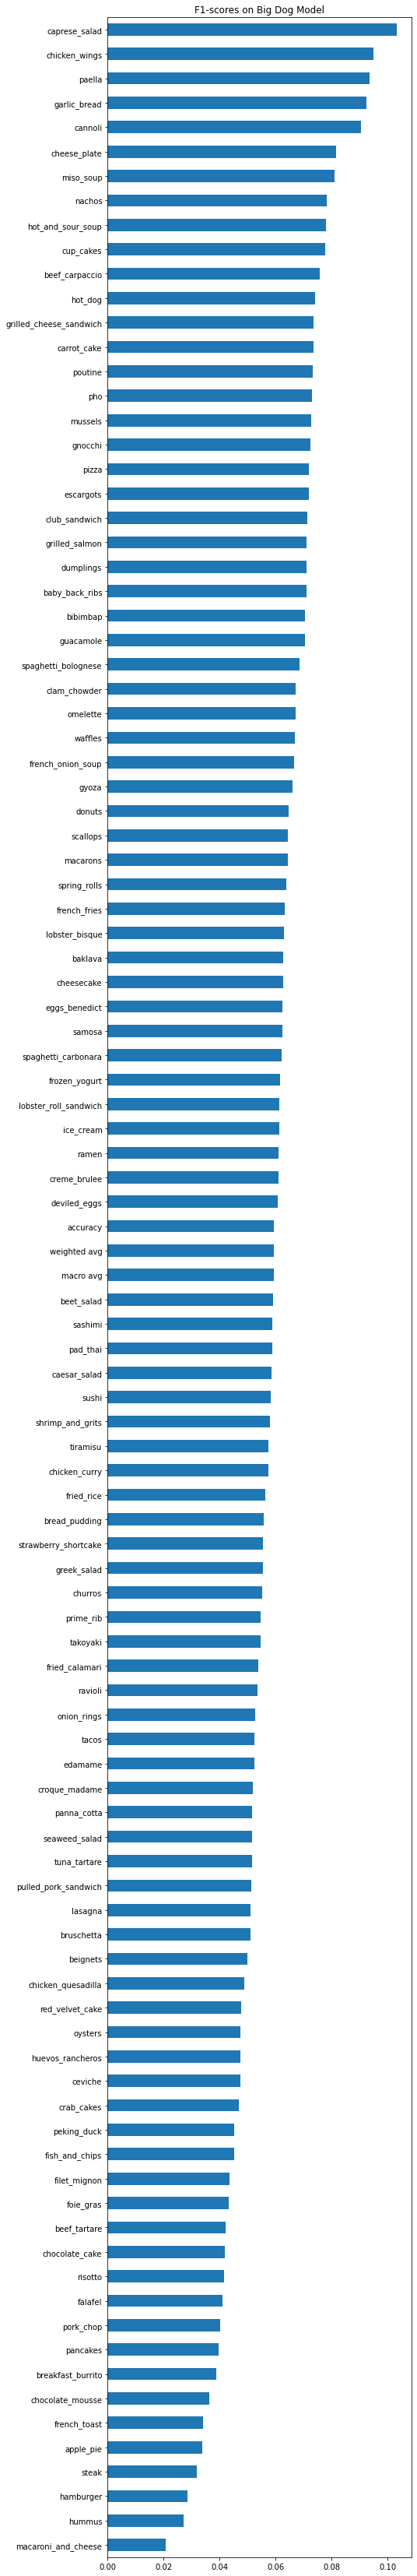

In [ ]:
import pandas as pd
df_score_report = pd.DataFrame(classification_report_dict)
df_score_report = df_score_report.transpose()

df_score_report["f1-score"].sort_values().plot(kind="barh", 
                                               figsize=(7,60),
                                               title="F1-scores on Big Dog Model");


In [ ]:
!tensorboard dev upload --logdir /content/allin_bigdog_model/finetune_all_layers_100_epochs/20220729-113108\
  --name "Fine tuned Food101_better_than_paper"\
  --description "Training results from Food101 fine tuned EFficientNetB0"\
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/allin_bigdog_model/finetune_all_layers_100_epochs/20220729-113108

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

Now we visualize how the model predicts! 

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
img = load_and_prep_image("/content/tf-sample-carrot-cake.jpg")
img.shape

In [ ]:
img_pred = loaded_model.predict(tf.expand_dims(img, axis=0))
img_pred = img_pred.argmax(axis=1)


In [ ]:
class_names[img_pred[0]]